In [11]:
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_manager import *
from utils.metrics import *
from utils.models import *
from utils.preprocessing import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_raw = get_train(dropNull=True)
df_train_raw, df_test_raw = split_by_date(df_raw, split_ratio=0.2)
df_raw.head()

data/optiver-trading-at-the-close/train.csv - loaded


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
row_id,,,,,,,,,,,,,,,,
0_0_0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0
0_0_1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0
0_0_2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0
0_0_3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0
0_0_4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0


In [8]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
        objective='reg:squarederror',
        max_depth=8,
        subsample=0.6,
        colsample_bytree=0.5,
        learning_rate=0.01,
        reg_lambda=1,
        reg_alpha=0.5,
        n_estimators=3500,
        random_state=42,
        verbosity=0
    )

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

cols = [
    'stock_id',
    'seconds_in_bucket',
    'reference_price',
    'matched_size',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'imbalance_size_rel',
]

xgb = XGBRegressor(
        objective='reg:squarederror',
        max_depth=8,
        subsample=0.6,
        colsample_bytree=0.5,
        learning_rate=0.01,
        reg_lambda=1,
        reg_alpha=0.5,
        n_estimators=3500,
        random_state=42,
        verbosity=0
    )

models_dict = {
    'model null' :(Model_base(), Preprocessing_null()),
    'model baseline':(Imbalanced(), Preprocessing_null()),
    'model baseline linReg':(Sklearn(LinearRegression()), RestrictCols(['imbalance_buy_sell_flag'])),
    'model linReg +':(
        Sklearn(LinearRegression()), 
        ChainPrepro((
            Preprocessing_base(),
            RestrictCols(cols)))),
    'model xgb +':(
        Sklearn(xgb), 
        ChainPrepro((
            Preprocessing_base(),
            RestrictCols(cols)))),
    'model linReg + poly':(
        Sklearn(LinearRegression()), 
        ChainPrepro((
            Preprocessing_base(),
            RestrictCols(cols),
            PolynomialFeatures(2)
            ))),
    'model xgb + poly':(
        Sklearn(xgb), 
        ChainPrepro((
            Preprocessing_base(),
            RestrictCols(cols),
            PolynomialFeatures(2)
            ))),

}
alphas = [round(10**(alpha/3)*0.001,4) for alpha in range(0,13)]
lasso_dict = {f'Lasso_{a}': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols)))
    ) for a in alphas}

Ridge_dict = {f'Ridge_{a}': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols)))
    ) for a in alphas}

lasso_dict_poly = {f'Lasso_{a} poly': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols),
        PolynomialFeatures(2)
        ))
    ) for a in alphas}

Ridge_dict_poly = {f'Ridge_{a} poly': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols),
        PolynomialFeatures(2)
        ))
    ) for a in alphas}

models_dict = {**models_dict,**lasso_dict, **Ridge_dict}

score=[]
data_res=[]
for name, pipe in tqdm(models_dict.items()):
    print(name)
    model, preprocess = pipe
    df_res_train, df_res_test, mae_train, mae_test = train_test_score_fast(df_train_raw, df_test_raw, model=model, preprocess=preprocess)
    score.append((name, mae_train, mae_test))
    data_res.append((name, df_res_train, df_res_test))


  0%|          | 0/31 [00:00<?, ?it/s]

model null


  6%|▋         | 2/31 [00:00<00:08,  3.60it/s]

model baseline


 10%|▉         | 3/31 [00:00<00:06,  4.30it/s]

model baseline linReg
model linReg +


 13%|█▎        | 4/31 [00:04<00:46,  1.74s/it]

model xgb +


 16%|█▌        | 5/31 [06:24<59:53, 138.21s/it]

Lasso_0.001


 19%|█▉        | 6/31 [06:29<38:38, 92.76s/it] 

Lasso_0.0022


 23%|██▎       | 7/31 [06:33<25:32, 63.87s/it]

Lasso_0.0046


 26%|██▌       | 8/31 [06:38<17:15, 45.01s/it]

Lasso_0.01


 29%|██▉       | 9/31 [06:43<11:51, 32.34s/it]

Lasso_0.0215


 32%|███▏      | 10/31 [06:47<08:18, 23.72s/it]

Lasso_0.0464


 35%|███▌      | 11/31 [06:51<05:55, 17.80s/it]

Lasso_0.1


 39%|███▊      | 12/31 [06:56<04:21, 13.74s/it]

Lasso_0.2154


 42%|████▏     | 13/31 [07:00<03:16, 10.91s/it]

Lasso_0.4642


 45%|████▌     | 14/31 [07:04<02:31,  8.89s/it]

Lasso_1.0


 48%|████▊     | 15/31 [07:09<01:59,  7.48s/it]

Lasso_2.1544


 52%|█████▏    | 16/31 [07:13<01:37,  6.48s/it]

Lasso_4.6416


 55%|█████▍    | 17/31 [07:17<01:21,  5.84s/it]

Lasso_10.0


 58%|█████▊    | 18/31 [07:22<01:10,  5.42s/it]

Ridge_0.001


 61%|██████▏   | 19/31 [07:26<01:03,  5.25s/it]

Ridge_0.0022


 65%|██████▍   | 20/31 [07:31<00:56,  5.15s/it]

Ridge_0.0046


 68%|██████▊   | 21/31 [07:36<00:50,  5.05s/it]

Ridge_0.01


 71%|███████   | 22/31 [07:41<00:45,  5.11s/it]

Ridge_0.0215


 74%|███████▍  | 23/31 [07:47<00:40,  5.12s/it]

Ridge_0.0464


 77%|███████▋  | 24/31 [07:51<00:35,  5.02s/it]

Ridge_0.1


 81%|████████  | 25/31 [07:56<00:29,  4.99s/it]

Ridge_0.2154


 84%|████████▍ | 26/31 [08:01<00:24,  4.92s/it]

Ridge_0.4642


 87%|████████▋ | 27/31 [08:06<00:19,  4.97s/it]

Ridge_1.0


 90%|█████████ | 28/31 [08:11<00:15,  5.01s/it]

Ridge_2.1544


 94%|█████████▎| 29/31 [08:16<00:09,  4.92s/it]

Ridge_4.6416


 97%|█████████▋| 30/31 [08:21<00:04,  4.85s/it]

Ridge_10.0


100%|██████████| 31/31 [08:26<00:00, 16.33s/it]


,score_train,score_test
model linReg +,6.495051,6.059715
Ridge_1.0,6.495212,6.059865
Lasso_1.0,6.495212,6.059865
Lasso_2.1544,6.495212,6.059865
Ridge_2.1544,6.495212,6.059865
Lasso_4.6416,6.495212,6.059865
Ridge_4.6416,6.495212,6.059865
Lasso_10.0,6.495212,6.059865
Ridge_10.0,6.495212,6.059865
Lasso_0.4642,6.495226,6.059879


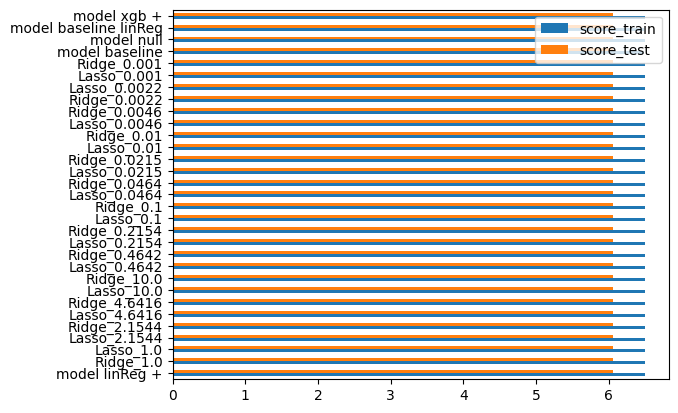

In [10]:
name, score_train, score_test = zip(*score)
df_score = pd.DataFrame({
    'score_train':score_train,
    'score_test':score_test}, index = name
)

df_score.sort_values(by='score_test',inplace=True)
df_score.plot.barh()
display(df_score)